<a href="https://www.kaggle.com/code/jayyanamandala/dl-nn-sennet-hoa-resnet-34?scriptVersionId=162218595" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Hacking the Human Vascular - using VGG16
<p style="font-size:1.0em; color:red;">Notebook setup includes Keras flow_from_dataframe setup</p>  

[RLE](https://en.wikipedia.org/wiki/Run-length_encoding)  
[Lossless Compression](https://en.wikipedia.org/wiki/Lossless_compression)  
_Run-length encoding_ (RLE) is a form of _lossless data compression_ in which runs of data (**sequences in which the same data value occurs in many consecutive data elements**) are stored as a single data value and count, rather than as the original run. This is most efficient on data that contains many such runs, for example, simple graphic images such as icons, line drawings, animations, etc. For files that do not have many runs, RLE could increase the file size.

References:
    [Cell Instance Segmentation Using Mask R-CNN](https://medium.com/mlearning-ai/cell-instance-segmentation-using-mask-r-cnn-c7a3810192ff#:~:text=Run-length%20encoding%20%28RLE%29%3A%20is%20a%20form%20of%20data,provide%20a%20RLE%20decoder%20to%20read%20those%20masks)
    https://www.kaggle.com/code/susnato/understanding-run-length-encoding-and-decoding  
    https://q-viper.github.io/2021/05/24/coding-run-length-encoding-in-python/  
    https://www.kaggle.com/paulorzp/run-length-encode-and-decode.  
    https://www.kaggle.com/code/susnato/understanding-run-length-encoding-and-decoding  

<p style="font-size:1.5em; color:red;">Please Upvote if you like this notebook</p>   

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow.keras as keras
import pandas as pd

2024-02-08 20:14:05.644314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 20:14:05.644485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 20:14:05.749202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, gc, re
from glob import glob

In [3]:
import warnings
import matplotlib.animation as animation

pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [4]:
import rasterio
from rasterio.plot import show
import cv2

In [5]:
# Image Uagmentation related packages
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import load_img, img_to_array, array_to_img
# from keras.utils.image_utils import load_img, img_to_array, array_to_img

## Pointers to datasets

In [6]:
train_data_path = '/kaggle/input/blood-vessel-segmentation/train'
test_data_path = '/kaggle/input/blood-vessel-segmentation/test'
image_label_size = (224,224)
data_input_path = '/kaggle/input/blood-vessel-segmentation/'

SIZE = 224
SIZE_F = 224
TH = 0.51

In [7]:
def get_image_path(path):
    return np.array(Image.open(path))

In [8]:
def get_image(path, size=(224,224), scale=False, debug=False):
    """ 
    function to return resized and scaled image - used PIL package
    params: path - path to image
    size: as a tuple - width. height - default 224,224
    scale: default False - only scale if True
    debug: False
    
    returns: resized image in format float32 and scaled by 255

    For large tiff images you cuse rasterio library for geospatial data.
    the data type is inferred from the input image
    
    """
    try:
        # image = Image.open(path)
        with rasterio.open(path) as image:
            image = rasterio.plot.reshape_as_image(image.read())
        
        if debug:
            print(f'image format: {image.format}')
            print(f'image size: {image.size}')
            print(f'image mode: {image.mode}')
                  
        # reshape image
        if scale:
            # image = image.resize(size)
            data = tf.image.resize(image, size)
            # data = img_to_array(image)
        else:
            # data = np.asarray(image)        # convert to array
            data = img_to_array(image)
        
        if debug:
            print(f'image array type: {data.dtype}')
            print(f'image size: {data.min()}, {data.max()}')
  
          # scale image
          # data = data.astype('float32')
        
        data /= 255.
        return data
      
    except:
        # don't raise exception
        # print('No such file', path)
        pass

In [9]:
def get_image_path(path):
    return np.array(Image.open(path))

In [10]:
# ref: https://www.kaggle.com/code/nimaiji/segnet-tensorflow-blood-vessel-segmentation
def preprocess_image(source, is_image=False):
    if is_image:
        image = source    
    else:
        image = get_image(source)
    
    if image.ndim > 2 and image.shape[2] > 1:
        image = image[...,0]
        
    image = image / SIZE_F
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    if image.ndim == 2:
        image = image[..., tf.newaxis]
        
    if image.ndim != 3:
        raise ValueError('Image tensor must be 3 dimensions [height, width, channels]')
        
    return tf.image.resize(image, [SIZE, SIZE])

In [11]:
# ref: https://www.kaggle.com/code/nimaiji/segnet-tensorflow-blood-vessel-segmentation
def preprocess_label(source, is_image=False):
    if is_image:
        label = source
    else:
        label = get_image(source)
    
    if label.ndim > 2 and label.shape[2] > 1:
        label = label[..., 0]
        
    label = label / SIZE_F if label.max() > 1 else label
    
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    if label.ndim == 2:
        label = label[..., tf.newaxis]
    
    # Ensure mask tensor is 3D at this point
    if label.ndim != 3:
        raise ValueError('Label tensor must be 3 dimensions [height, width, channels]')
        
    label = tf.image.resize(label, [SIZE, SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    label = tf.where(label > TH, 1., 0.)
    
    return label

## Sample graph to show image and mask

one image:  /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/1450.tif
one label:  /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels/1450.tif


/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


data  shape:  (1303, 912, 1)  type:  float32
label shape:  (1303, 912, 1)  type:  float32


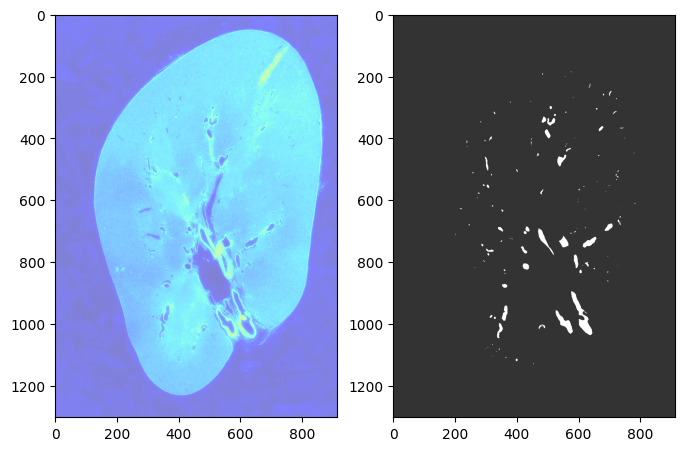

In [12]:
one_train_image = train_data_path+'/kidney_1_dense/images/1450.tif'
one_train_label = train_data_path+'/kidney_1_dense/labels/1450.tif'
print('one image: ', one_train_image)
print('one label: ', one_train_label)

# (1303, 912)
data = get_image(one_train_image, scale=False)
label = get_image(one_train_label, scale=False)
print('data  shape: ', data.shape,' type: ', data.dtype)
print('label shape: ', label.shape,' type: ', label.dtype)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(data, cmap='jet', alpha=0.5, animated=True)

plt.subplot(122)
plt.imshow(label, cmap="Greys_r", alpha=0.8, animated=False)

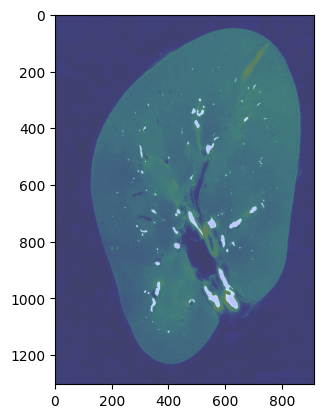

In [13]:
# resized data and label
data = get_image(one_train_image)
label = get_image(one_train_label)

plt.imshow(data, cmap='jet', alpha=0.5, animated=True)
plt.imshow(label, cmap="Greys_r", alpha = 0.5,  animated=False)

In [14]:
def show_images(dataset='kidney_1_dense', show_images=True, show_labels=True):

    # path to images dir
    if show_images:
        images_dir = os.path.join(train_data_path, dataset, "images")
    else:
        images_dir = os.path.join(train_data_path, dataset, "labels")

    n = 1
    plt.figure(figsize=(9,9))
    while n < 10:
        images_dir = images_dir.replace(os.sep, '/')   # import to have on WINDOWS
        try:
            # i = str(np.random.permutation(glob(images_dir+'/*.tif'))).split('\n')[1].split('\\\\')[1].strip('\'')
            x = np.random.permutation(2000)[1]
            i= f'{x:04d}'
            # print('showing id: ', i)
            plt.subplot(3, 3, n )

            show_img = True
            if show_images:
                one_train_image = train_data_path+'/'+dataset+'/images/'+i+'.tif'
                # print(type(one_train_image))
                data = get_image(one_train_image, debug=False)
                # print(type(data))
                plt.imshow(data, cmap='jet', alpha=0.5, animated=True)

            if show_labels and show_img:
                one_train_label = train_data_path+'/'+dataset+'/labels/'+i+'.tif'
                label = get_image(one_train_label)
                plt.imshow(label, cmap="Greys_r", alpha=0.5, animated=True)

            if show_img:
                plt.title(f'Image Id:{i}')
                plt.axis('off')
            n += 1
        except:
            pass

## show _ONLY_ image and _NO_ mask

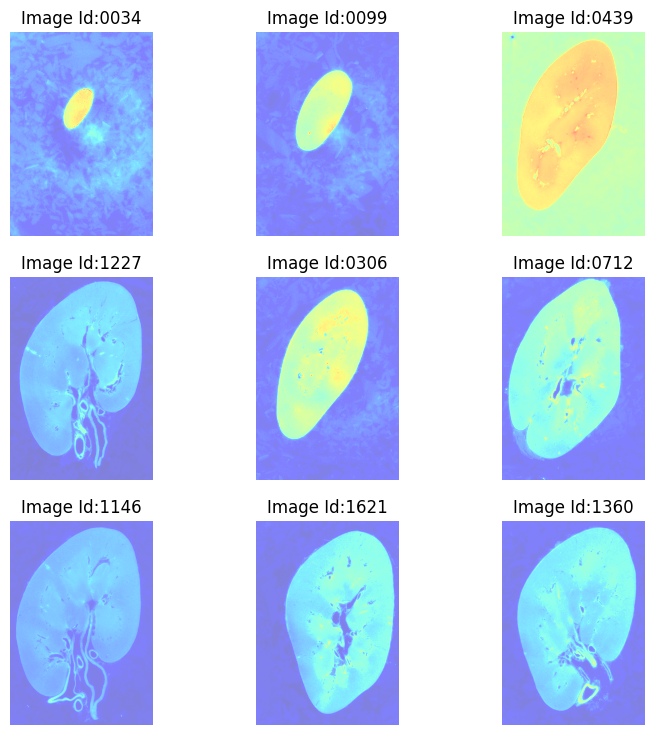

In [15]:
show_images(dataset='kidney_1_dense', show_labels=False)

## show image and mask

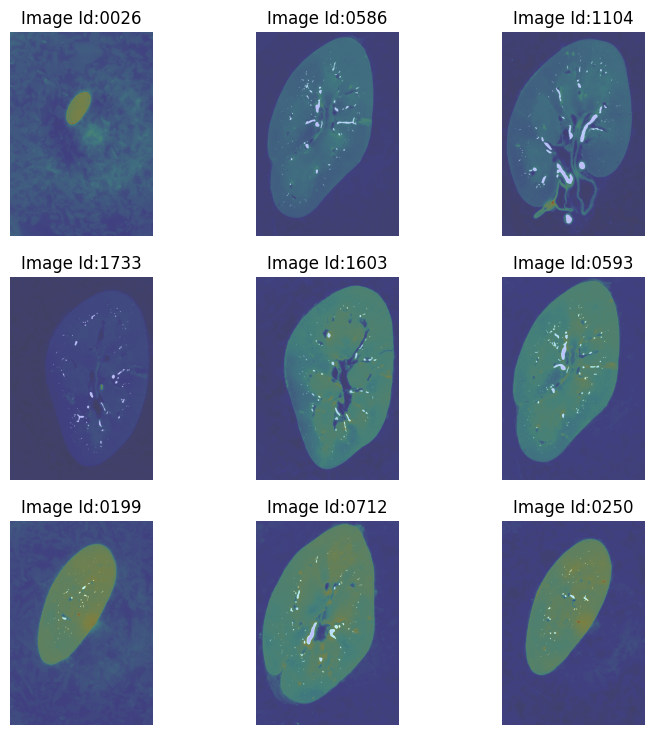

In [16]:
show_images(dataset='kidney_1_dense', show_labels=True)

 ## show_images kidney_3_dense

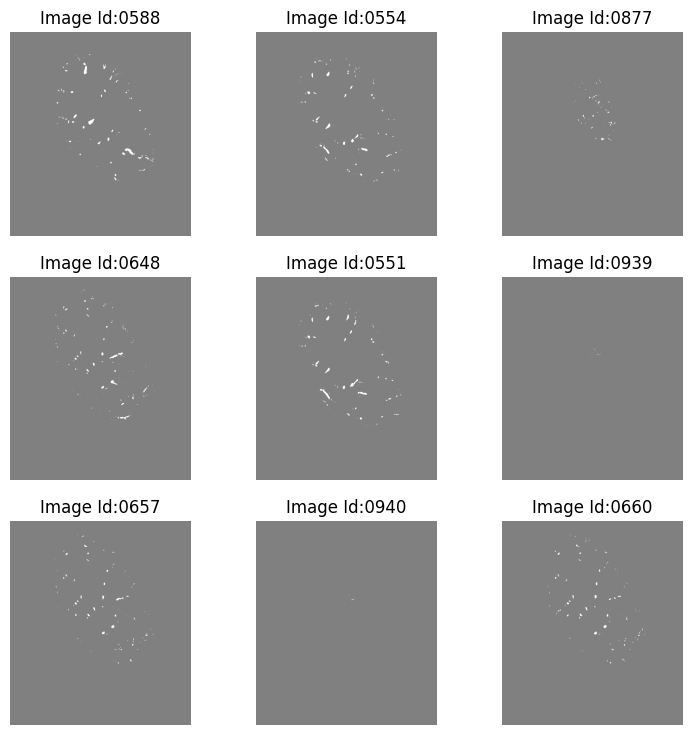

In [17]:
show_images(dataset='kidney_3_dense', show_images=False)

`Nghi Huynh` [Cell Instance Segmentation Using Mask R-CNN](https://colab.research.google.com/drive/1zvcp88bTlly_XMkK6G6HXZvA_vk5MP7i?usp=sharing)   
The training annotations are provided as run length encoded (RLE) masks, and the images are in TIF format.  
train_rles.csv - IDs and Masks for training objects

[Mask R-CNN](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46)
<pre>
  RCNN: (regional convolutional neural network) is a state-of-the-art in terms of image segmentation and instance segmentation. 
  Mask R-CNN was built on top of Faster R-CNN, a popular framework for object detection. There are two stages in this framework:
  The first stage is called a Region Proposal Network (RPN), proposes candidate object bounding boxes.
  The second stage extracts features from each candidate box and performs classification, bounding-box regression and a binary mask.
</pre>

[cited in](https://medium.com/mlearning-ai/cell-instance-segmentation-using-mask-r-cnn-c7a3810192ff#:~:text=Run-length%20encoding%20%28RLE%29%3A%20is%20a%20form%20of%20data,provide%20a%20RLE%20decoder%20to%20read%20those%20masks.) "Run-length encoding (RLE): is a form of data compression. Images can be stored in bit map and compressed using RLE algorithm. Since the masks are RL encoded, we need to provide a RLE decoder to read those masks."

In [18]:
#ref:https://www.kaggle.com/paulorzp/run-length-encode-and-decode.

# Run Length Encoding
def encode_mask_to_rle(img):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    mask = np.array(img)
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle=='':
        rle = '1 0'
    return rle

# Run Lemgth Decoding
def decode_rle_to_mask(rle, height, width, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1, 3))
    if viz:
        color = np.random.rand(3)
    else:
        color = [1,1,1]
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1]), :, :] = color

    return mask.reshape(height, width, 3)

In [19]:
# references
#   https://www.kaggle.com/code/susnato/understanding-run-length-encoding-and-decoding
def image_to_rle(path):
    """
    params:  path - abs-path to TIFF (image file)
    returns: RLE string (to create column in DF)
    """
    # reads image
    # converts to numpy array 
    # flattens into a 1-dimensional series of pixels
    # creates and returns RLE

    try:
        # image = Image.open(path)
        image = cv2.imread(path)
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)             # what does this do
        # mask = (image-np.min(image))/(np.max(image)-np.min(image))

        pixels = mask.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        rle = ' '.join(str(x) for x in runs)
        if rle=='':
            rle = '1 0'
        return rle
    except:
        # don't raise exception
        print('No such file', path)
        pass 

In [20]:
## create ids and images
#
def create_images_labels_dict(list_of_dirs, data_path, create_labels=True, create_links_only=False):

    """
    usage: list of directories to create images and labels from
    params: 
        list_of_dirs   - directories under different segnebtation categories
        data_path      - absolute dir path to top of categories
        create_labels  - create label images arrays - if False not created

        return        - a dictionary of IDs - each pointing to img_to_array
                   - use values in run to fit/evaluate/predict
                   - and for test use IDs to create submission file
    """
    labels_dict = {}
    images_dict = {}
    
    dict_index = 0   # using as an index for dictionary
    
    # get images and corresponsing labels for each image
    for dataset in list_of_dirs:
  
        # path to images dir
        _images_dir = data_path+'/'+dataset+"/images"
    
        # if create_labels is true, check if labels directory exist - unset if don't exist
        _labels_dir = data_path+'/'+dataset+"/labels"
        create_labels=True if os.path.isdir(_labels_dir) else False
    
        # print(_images_dir)
        # print(_labels_dir)
    
        # preprocess_labels_images(i, ret_image=True, is_image=False)
        # split on image name and create a dictionary path to image + id
        for img_test in os.listdir(_images_dir):
            img_conv = os.path.join(_images_dir, img_test)
            
            # print(img_conv)
            newPath = img_conv.replace(os.sep, '/')
        
            # print(newPath)
            img_split = os.path.split(newPath)[1]
            
            # print(img_split)
            # img_conv = os.path.join(test_images_dir,img_test)
        
            _label = dataset+'_'+(img_split).split('.')[0]
        
            if create_labels:
                label_conv = os.path.join(_labels_dir, img_split)
                new_label_Path = label_conv.replace(os.sep, '/')
                # False since we are inputting pointer to file
                _label_arry = preprocess_label(new_label_Path, False)

                # _label_arry = image_to_rle(new_label_Path)

            # convert image to array
            if create_links_only: 
                _img_arry = newPath
            else:
                # _img_arry = get_image(newPath)
                # False since we are inputting pointer to file
                _img_arry = preprocess_image(newPath, False)

            # append to dict_of_test_images
            if create_labels:
                entries = {'id': _label, 'image': _img_arry, 'label': _label_arry}
            else:
                entries = {'id': _label, 'image': _img_arry}
            
            images_dict[dict_index] = entries     # create dictionary
            dict_index += 1    # using as an index for dictionary
  
    # return dictionary of labels and images
    return images_dict


In [21]:
# create test-ids and test_images -- only run this to get Ids
####################################################################
## create test-ids and test_images
list_of_test_dirs  = ['kidney_5', 'kidney_6']
test_images_dict = {}
test_images_dict = create_images_labels_dict(list_of_dirs=list_of_test_dirs, 
                                             data_path=test_data_path, 
                                             create_labels=False, 
                                             create_links_only=False)
len(test_images_dict.keys())

test_images_df = pd.DataFrame.from_dict(data=test_images_dict, orient='index')

In [22]:
test_images_df.info(), test_images_df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      object
 1   image   6 non-null      object
dtypes: object(2)
memory usage: 144.0+ bytes


(None, (6, 2))

In [23]:
# not using in this book - running our of memory also need to convert to 3D
#
# Get images into dictionaries - train - we only create links - no array
# MemoryError: Unable to allocate 4.53 MiB for an array with shape (1303, 912) and data type float32
# list_of_train_dirs = ['kidney_1_dense']
# train_images_dict = {}
# train_images_dict = create_images_labels_dict(list_of_dirs=list_of_train_dirs, 
#                                                      data_path=train_data_path, 
#                                                      create_labels=True,
#                                                      create_links_only=True)
# len(train_images_dict.keys())
# train_images_df = pd.DataFrame.from_dict(data=train_images_dict, orient='index')

In [24]:
# not using in this book - running our of memory also need to convert to 3D
#
# Get images into dictionaries - validation - we only create links - no array
# list_of_validation_dirs = ['kidney_2']
# val_images_dict = create_images_labels_dict(list_of_dirs=list_of_validation_dirs, 
#                                                    data_path=train_data_path, 
#                                                    create_labels=True,
#                                                    create_links_only=True)

# len(val_images_dict.keys())
# val_images_df = pd.DataFrame.from_dict(data=val_images_dict, orient='index')


In [25]:
## create Keras ImageDataGenerator
## Augment training dataset - setup training generator

# REF: https://www.kaggle.com/code/hrmello/flow-from-dataframe-a-memory-friendly-approach
# Not using in this notebook - not enough memory since we convert Gray -to- 3RGB
# datagen = ImageDataGenerator(rescale=1.0/255.0)
# train_generator = datagen.flow_from_dataframe(dataframe=train_images_df,
#                                               batch_size=16,
#                                               x_col='image',
#                                               y_col='label',
#                                               directory=None,           # dir paths in columns are absolute - so set to None
#                                               target_size=(224,224),
#                                               shuffle=True,
#                                               seed=42,
#                                               class_mode='input',
#                                               # subset='training',
#                                              )


# valgen = ImageDataGenerator(rescale= 1./255)              
# val_generator = valgen.flow_from_dataframe(dataframe=val_images_df,
#                                             batch_size=16,
#                                             directory=None,        # dir paths in columns are absolute - so set to None
#                                             x_col='image',
#                                             y_col='label',
#                                             target_size=(224,224),
#                                             # subset='validation',
#                                             class_mode='input',
#                                              )

# testgen = ImageDataGenerator(rescale= 1./255)
# test_generator = testgen.flow_from_dataframe(dataframe=test_images_df,
#                                              batch_size=6,
#                                              x_col='image',
#                                              y_col=None,            # no loabel
#                                              directory=None,        # dir paths in columns are absolute - so set to None
#                                              shuffle=False,         # so predictions are done in the same order
#                                              target_size=(224,224),
#                                              class_mode=None,       # no labels
#                                              )

# training_steps=train_generator.n//train_generator.batch_size
# validation_steps=val_generator.n//val_generator.batch_size
# print(f'training_steps: {training_steps} - validation_steps:{validation_steps}')

In [26]:
# Keras import
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Flatten, Dense, Reshape, Dropout, BatchNormalization, Input, Add
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers import Activation, Reshape, UpSampling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras_core import ops
from keras.utils import Progbar
from keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
from tensorflow.keras.layers import ReLU
from keras.initializers import random_normal, random_uniform, glorot_normal, glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
import keras.backend as K

Using TensorFlow backend


In [27]:
# ref: https://www.kaggle.com/code/awsaf49/sennet-hoa-kerascv-starter-notebook-train
import keras.backend as K
class CustomLoss(keras.losses.Loss):
    def __init__(self, smooth=1e-4, name="custom_loss"):
        super().__init__(name=name)
        # 1e-4 is default
        self.smooth = smooth

    # sub-class must have 'call' function
    def call(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = y_true_f * y_pred_f
        score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return 1. - score


In [28]:
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 2
        
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
    
def dice_coef(y_true, y_pred, smooth=1):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)
    # return sparse_categorical_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


## Convert images to Numpy arrays

In [29]:
# process train data
image_files = []
label_files = []
image_files = glob(data_input_path+'train/kidney_1_dense/images/*')
label_files = glob(data_input_path+'train/kidney_1_dense/labels/*')
images = np.array([preprocess_image(i, False) for i in image_files])
labels = np.array([preprocess_label(i, False) for i in label_files])

images.shape, labels.shape

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((2279, 224, 224, 1), (2279, 224, 224, 1))

In [30]:
# process test data
image_5_files = glob(data_input_path+'test/kidney_5/images/*')
image_6_files = glob(data_input_path+'test/kidney_6/images/*')
testX5 = np.array([preprocess_image(i, False) for i in image_5_files])
testX6 = np.array([preprocess_image(i, False) for i in image_6_files])

In [31]:
# combine arrays - 5 and 6
# testX = np.append(testX5, testX6, axis=0)
testX = np.concatenate((testX5, testX6), axis=0)
testX.shape

(6, 224, 224, 1)

In [32]:
# from keras.utils import plot_model
# install pydot and graphviz
# plot_model(model, show_shapes=True, expand_nested=True, to_file='model.png')
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY= train_test_split(images, labels, test_size=0.3, random_state=42)
trainX.shape, valX.shape, testX.shape, trainY.shape, valY.shape

((1595, 224, 224, 1),
 (684, 224, 224, 1),
 (6, 224, 224, 1),
 (1595, 224, 224, 1),
 (684, 224, 224, 1))

## ResNet 34 layers!

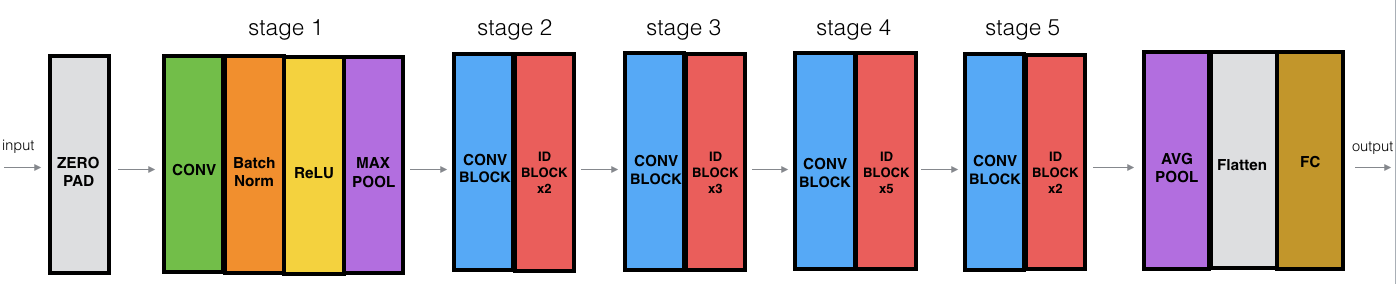
image from Deeplearning.ai course (Deep Learning Specialization)

In [33]:
# from Deeplearning.ai course
#   - taught by Andrew Ng
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. here X_shortcut is added to n/w later - Residual network. 
    X_shortcut = X
    
    # If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    ## Set the padding = 'same'
    ## kernel_size = f
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path
    ## Set the padding = 'valid'
    ## F3 has NO activation since ResNet is inserted
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid',  kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X) 

    return X

## CONV Block

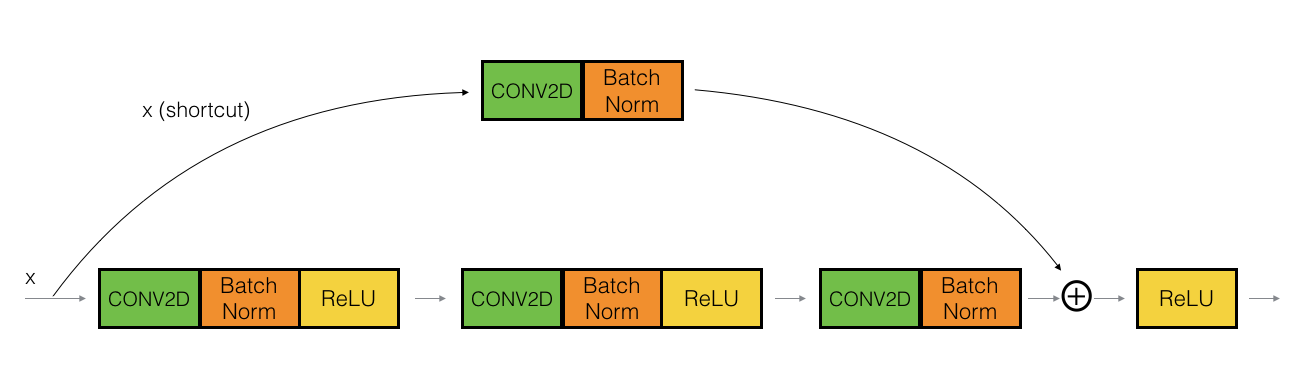
mage from Deeplearning.ai course (Deep Learning Specialization)

In [34]:
# from Deeplearning.ai course
#   - taught by Andrew Ng
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    # Final step: Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [35]:
# customize block for SenNet_HOA 
def ResNet10(input_shape = (214,214,1), classes = 224 * 224, training=True):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
  
    # cut down on the number of blocks to use
    # Define the input as a tensor with shape input_shape  - input here is (224, 224, 1)
    X_input = Input(input_shape)

    # augment images - Random
    # ref: https://www.tensorflow.org/guide/keras/preprocessing_layers
    X = RandomBrightness(0.1)(X_input)
    X = RandomFlip('horizontal')(X)
    X = RandomContrast(0.1)(X)
    X = RandomRotation(0.1)(X)

    # Zero-Padding
    # X = ZeroPadding2D((3, 3))(X_input)
    X = ZeroPadding2D((3, 3))(X)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    """
    ### CONV Block Flow
    #    ResNet = Input ->
    #    Conv2D -> BatchNormalization -> ReLU -> 
    #    Conv2D -> BatchNormalization -> ReLU -> 
    #    Conv2D -> BatchNormalization -> X
    #    ResNet -> Conv2d-> BatchNormalization -> ResNet
    #    Add()([X, ResNet]) -> ReLU

    ### Indentity Block Flow
    #    ResNet = Input ->
    #    Conv2D -> BatchNormalization -> ReLU -> 
    #    Conv2D -> BatchNormalization -> ReLU -> 
    #    Conv2D -> BatchNormalization -> X
    #    Add()([X, ResNet]) -> ReLU
    """
  
    # Stage 2  
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    print('after 20:', X.shape)
    X = identity_block(X, 3, [64, 64, 256])
    print('after 21:', X.shape)
    X = identity_block(X, 3, [64, 64, 256])
    print('after 22:', X.shape)
  
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    print('after 30:', X.shape)
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128,128,512])
    print('after 31:', X.shape)
    X = identity_block(X, 3, [128,128,512])
    print('after 32:', X.shape)
    X = identity_block(X, 3, [128,128,512])
    print('after 33:', X.shape)
  
    """
    # Take out TWO stage to speed up training 
    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256,256,1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    """
    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512,512,2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512,512,2048])
    X = identity_block(X, 3, [512,512,2048])
   

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X =  AveragePooling2D((2, 2))(X)
    # X =  MaxPooling2D()(X)
    # X =  AveragePooling2D((2, 2), strides=(2, 2))(X)
    ### END CODE HERE

    # Add Reshape to bring it down to 50176 - 214 x 214
    X = Reshape((224, 224, 2))(X)
    print('before flatten:', X.shape)
    # output layer
    # COMMENTING FOR NOW X = Flatten()(X)
    print('after flatten:', X.shape)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [36]:
import gc
gc.collect()

# build Model - ResNet 10
tf.keras.backend.set_learning_phase(True)

model = ResNet10(input_shape = (224, 224, 1), classes = 1)
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


after 20: (None, 55, 55, 256)
after 21: (None, 55, 55, 256)
after 22: (None, 55, 55, 256)
after 30: (None, 28, 28, 512)
after 31: (None, 28, 28, 512)
after 32: (None, 28, 28, 512)
after 33: (None, 28, 28, 512)
before flatten: (None, 224, 224, 2)
after flatten: (None, 224, 224, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 random_brightness (RandomB  (None, 224, 224, 1)          0         ['input_1[0][0]']             
 rightness)                                                                                       
                                                                                                  
 random_fli

In [37]:
# Compiles the model for training.
model.compile(optimizer='adam', 
              loss = bce_dice_loss,
              # loss='sparse_categorical_crossentropy',
              metrics=[dice_coef,iou_coef],
             )

In [38]:
# callbacks
scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

# saving in hdf5 is legacy format
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/resnet.keras', 
                                               verbose=1, save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

## fit and plot Model

In [39]:
import gc
gc.collect()

# with tf.device('/GPU:0'):
history = model.fit(trainX, trainY,
                    epochs=30,       # change this to run more passes - using 5 to show case notebook
                    batch_size=16,   # change to increase batch_size - use more to vary bins
                    validation_data=(valX, valY),
                    # callbacks = [checkpointer, early_stopping],
                    # callbacks = [checkpointer],
                    callbacks = [scheduler, early_stopping, checkpointer],
                   )

gc.collect()


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30


I0000 00:00:1707423510.741382      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - ETA: 0s - loss: 0.7769 - dice_coef: 0.0125 - iou_coef: 0.0063
Epoch 1: val_loss improved from inf to 0.88396, saving model to /kaggle/working/resnet.keras
100/100 [==============================] - 42s 169ms/step - loss: 0.7769 - dice_coef: 0.0125 - iou_coef: 0.0063 - val_loss: 0.8840 - val_dice_coef: 0.0116 - val_iou_coef: 0.0059 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.6479 - dice_coef: 0.0125 - iou_coef: 0.0063
Epoch 2: val_loss improved from 0.88396 to 0.76042, saving model to /kaggle/working/resnet.keras
100/100 [==============================] - 13s 127ms/step - loss: 0.6479 - dice_coef: 0.0125 - iou_coef: 0.0063 - val_loss: 0.7604 - val_dice_coef: 0.0116 - val_iou_coef: 0.0059 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 3/30
100/100 [==========================

1371

## Plots

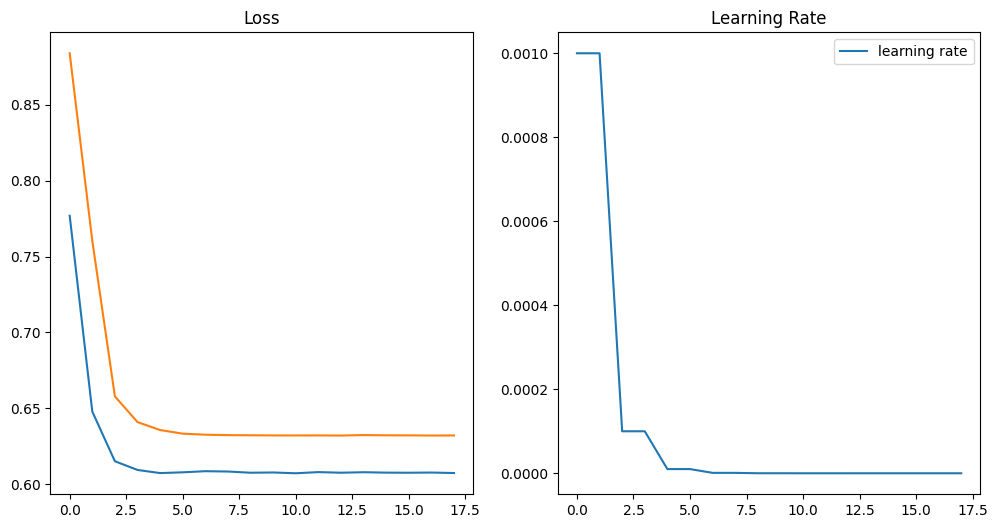

In [40]:
# history.history.keys()
# dict_keys(['loss', 'dice_coef', 'iou_coef', 'val_loss', 'val_dice_coef', 'val_iou_coef', 'lr'])
# plot loss
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')

plt.subplot(122)
plt.plot(history.history['lr'], label='learning rate')
plt.title('Learning Rate')
plt.legend()

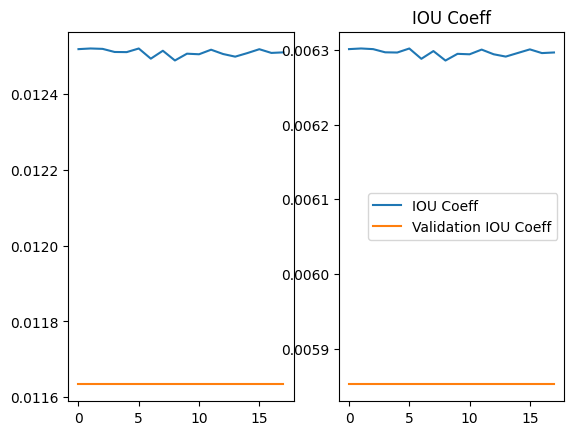

In [41]:
# plot accuracy
plt.subplot(121)
plt.plot(history.history['dice_coef'], label='Dice Coeff')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coeff')

plt.subplot(122)
plt.plot(history.history['iou_coef'], label='IOU Coeff')
plt.plot(history.history['val_iou_coef'], label='Validation IOU Coeff')
plt.title('IOU Coeff')
plt.legend()

## predict RLE for test data

In [42]:
predictions = model.predict(testX)

1/1 [==============================] - 1s 1s/step


In [43]:
predicted_labels = tf.image.resize(predictions, [1303, 912], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
print(np.mean(predicted_labels))
int_labels = (predicted_labels > TH)
print(int_labels.shape)

1.0
(6, 1303, 912, 1)


(1303, 912, 1)
1.0 0.37468123
True 0.44017333


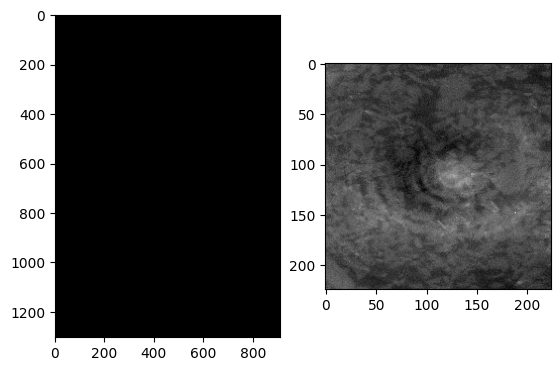

In [44]:
# print stats for one image and plot
print(int_labels[2].shape)
print(np.mean(int_labels[2]), np.mean(testX[4]))
print(np.max(int_labels[2]),  np.max(testX[4]))

plt.subplot(121)
plt.imshow(int_labels[2], cmap='gray')

plt.subplot(122)
plt.imshow(testX[2], cmap='gray')

In [45]:
rles = [encode_mask_to_rle(mask) for mask in int_labels]
submission = pd.DataFrame({
  "id": test_images_df.id,
  "rle": rles
})
submission.head()

,id,rle
0,kidney_5_0001,1 1188336
1,kidney_5_0002,1 1188336
2,kidney_5_0000,1 1188336
3,kidney_6_0001,1 1188336
4,kidney_6_0002,1 1188336


In [46]:
submission.to_csv("submission.csv", index=False)

`Bibliography`
<pre>
@misc{blood-vessel-segmentation,
    author = {Yashvardhan Jain, Katy Borner, Claire Walsh, Nancy Ruschman, Peter D. Lee, Griffin M. Weber, Ryan Holbrook,  Addison Howard},
    title = {SenNet + HOA - Hacking the Human Vasculature in 3D},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/blood-vessel-segmentation}
}
</pre>